In [102]:
import os
import sys; sys.path.append("~/HHbbgg_ETH_devel/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt


In [103]:
dirpath='/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_newcode_20180612/output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph.root'
treename='GluGluToHHTo2B2G_node_SM_13TeV_madgraph_13TeV_DoubleHTag_0'
treepath='tagsDumper/trees/'

In [104]:
df = rpd.read_root(dirpath,treepath+treename)

In [105]:
print any(df.isnull().any()) # no NANs in the dataframe

False


In [106]:
import ROOT
from ROOT import TFile, TH1F, TCanvas, gROOT, TLorentzVector,TH1,TH1F

In [107]:
final_dijetM = []
final_dijetPt = []
final_diHiggsM=[]
final_diHiggsPt=[]
final_MX=[]
final_jet1_pt=[]
final_jet2_pt=[]
for index, row in df.iterrows():
    dijetM = 0
    dijetPt = 0
    diHiggsM = 0
    diHiggsPt = 0
    jet1, jet2, diphoton = TLorentzVector(),TLorentzVector(),TLorentzVector()
    jet1_reg, jet2_reg = TLorentzVector(),TLorentzVector()
    jet1.SetPtEtaPhiM(row['leadingJet_pt']/row['leadingJet_bRegNNCorr'],row['leadingJet_eta'],row['leadingJet_phi'],row['leadingJet_mass'])
    jet2.SetPtEtaPhiM(row['subleadingJet_pt']/row['subleadingJet_bRegNNCorr'],row['subleadingJet_eta'],row['subleadingJet_phi'],row['subleadingJet_mass'])
    diphoton.SetPtEtaPhiM(row['diphoton_pt'],row['diphoton_eta'],row['diphoton_phi'],row['CMS_hgg_mass'])
    dijetM = (jet1+jet2).M()
    dijetPt = (jet1+jet2).Pt()
    diHiggsM = (jet1+jet2+diphoton).M()
    diHiggsPt = (jet1+jet2+diphoton).Pt()

    final_dijetM.append(dijetM)
    final_dijetPt.append(dijetPt)     
    final_diHiggsM.append(diHiggsM)
    final_diHiggsPt.append(diHiggsPt)
    final_MX.append(diHiggsM - dijetM-diphoton.M()+250)
    final_jet1_pt.append(jet1.Pt())
    final_jet2_pt.append(jet2.Pt())



In [108]:
df['dijetM_notregressed'] = final_dijetM
df['dijetPt_notregressed'] = final_dijetPt
df['diHiggsPt_notregressed'] = final_diHiggsPt
df['diHiggsM_notregressed'] = final_diHiggsM
df['MX_notregressed'] = final_MX
df['dijetPt_higgsM_notregressed'] = [final_dijetPt[i]/final_diHiggsM[i] for i in range(len(final_diHiggsM))]
df['dijetPt_higgsM'] = df['dijet_pt']/df['diHiggs_mass']
df['jet1_pt_notregressed'] = final_jet1_pt
df['jet2_pt_notregressed'] = final_jet2_pt

In [109]:
cut = 'jet1_pt_notregressed>20 & jet2_pt_notregressed>20 & subleadingJet_pt>20 & leadingJet_pt>20 '
df = df.query(cut)

In [110]:
jets='subleading,leading'.split(',')
ofwhat='pt,eta'.split(',')
ranges = [[20,300],[-3.,3]]
binning = [50,20]
colors=['r','g']
colors2=['b','c']
markers=['s','o']

In [111]:
pathsave='/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/applied_breg_ptcut/'

(51,)
50
(51,)
50


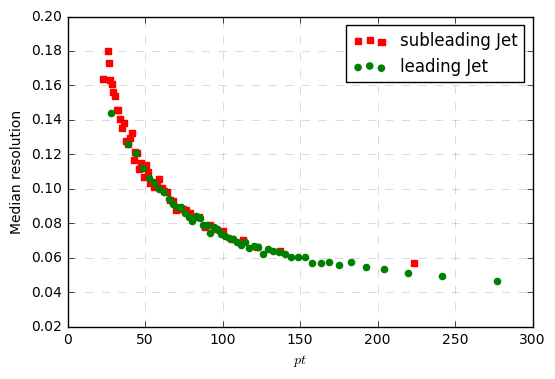

(21,)
20
(21,)
20


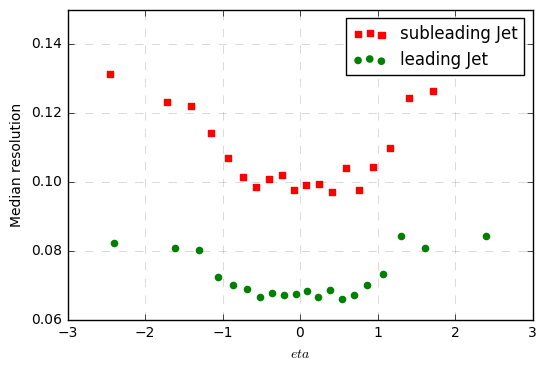

In [112]:
for num_what,what in enumerate(ofwhat):
    for num,obj in enumerate(jets):
        X_what = (df['%sJet_%s'%(obj,what)]).values.reshape(-1,1)
        res = (df['%sJet_bRegNNResolution'%(obj)]).values.reshape(-1,1)
        ran = ranges[num_what]
        bins = binning[num_what]
        
        bins, y_mean_pt, y_std_pt, y_qt_pt = preprocessing.profile(res,X_what,range=ran,bins=bins,uniform=False,quantiles=np.array([0.25,0.4,0.5,0.75]))
        y_median_pt = y_qt_pt[2]
        y_25_pt,y_40_pt,y_75_pt = y_qt_pt[0],y_qt_pt[1],y_qt_pt[3]
        y_iqr2_pt =  y_qt_pt[0],y_qt_pt[3]
        err_iqr2 =  0.5*(y_qt_pt[3]-y_qt_pt[0])
        binc = 0.5*(bins[1:]+bins[:-1])
     #   print bins[:10]

       # plt.scatter(binc,y_mean_pt,color=colors[num],marker=markers[num],label='%s Jet'%obj) #mean
        plt.scatter(binc,y_median_pt,color=colors[num],marker=markers[num],label='%s Jet'%obj)

    plt.grid(alpha=0.2,linestyle='--',markevery=2)
    axes = plt.gca()
    ymin, ymax = (plt.gca()).get_ylim()
    xmin, xmax = (plt.gca()).get_xlim()
    lgd = plt.legend(loc="upper right")
    plt.xlabel('$%s$'%what)
    plt.ylabel('Median resolution')
    savename='plot_%sJet_%s'%(obj,what)
    plt.savefig(pathsave+savename+'.pdf')
    plt.show()


(51,)
50
[ 20.          25.72543919  26.43198105  27.3031102   28.13353127
  29.06936741  30.07031067  31.08483803  32.29089523  33.32019798]
(51,)
50
[ 20.          36.10923531  41.5569516   46.57025452  50.57954208
  54.29685249  57.53916031  60.84511841  63.97254181  66.74658035]


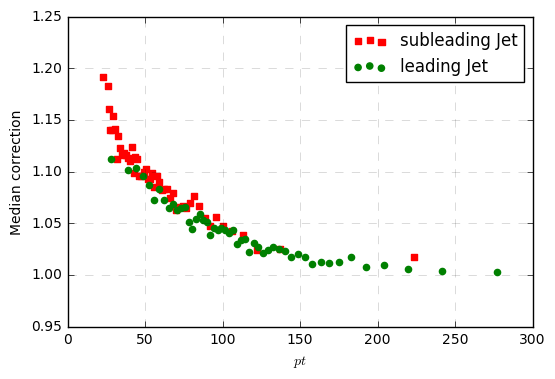

(21,)
20
[-3.         -1.90014922 -1.54347061 -1.26759071 -1.0267926  -0.82969739
 -0.65150118 -0.47882536 -0.3135551  -0.15714157]
(21,)
20
[-3.         -1.79213312 -1.42933532 -1.16792569 -0.95907817 -0.76936407
 -0.59790317 -0.43061276 -0.28428382 -0.12590709]


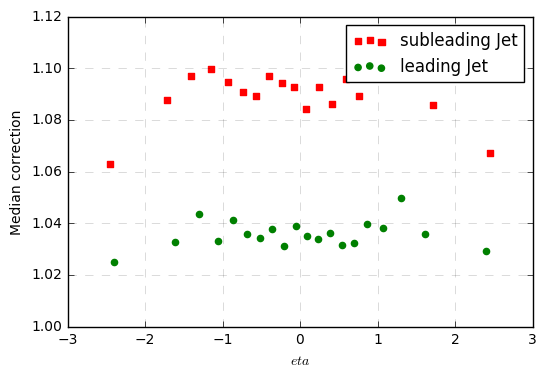

In [113]:
for num_what,what in enumerate(ofwhat):
    for num,obj in enumerate(jets):
        X_what = (df['%sJet_%s'%(obj,what)]).values.reshape(-1,1)
        res = (df['%sJet_bRegNNCorr'%(obj)]).values.reshape(-1,1)
        ran = ranges[num_what]
        bins = binning[num_what]
        
        bins, y_mean_pt, y_std_pt, y_qt_pt = preprocessing.profile(res,X_what,range=ran,bins=bins,uniform=False,quantiles=np.array([0.25,0.4,0.5,0.75]))
        y_median_pt = y_qt_pt[2]
        y_25_pt,y_40_pt,y_75_pt = y_qt_pt[0],y_qt_pt[1],y_qt_pt[3]
        y_iqr2_pt =  y_qt_pt[0],y_qt_pt[3]
        err_iqr2 =  0.5*(y_qt_pt[3]-y_qt_pt[0])
        binc = 0.5*(bins[1:]+bins[:-1])
        print bins[:10]

        plt.scatter(binc,y_median_pt,color=colors[num],marker=markers[num],label='%s Jet'%obj)

    plt.grid(alpha=0.2,linestyle='--',markevery=2)
    axes = plt.gca()
    ymin, ymax = (plt.gca()).get_ylim()
    xmin, xmax = (plt.gca()).get_xlim()
    lgd = plt.legend(loc="upper right")
    plt.xlabel('$%s$'%what)
    plt.ylabel('Median correction')
    savename='plot_correction_%sJet_%s'%(obj,what)
    plt.savefig(pathsave+savename+'.pdf')
    plt.show()


### Dijet mass improvement

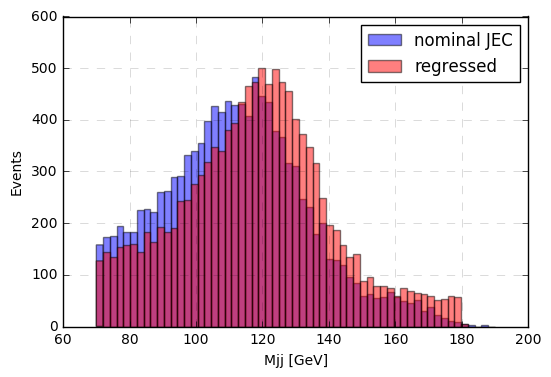

In [114]:
plt.clf()
bins = np.linspace(70, 190, 60)
n,bins,patches = plt.hist(df['dijetM_notregressed'],bins=bins,color='blue',alpha=0.5,label='nominal JEC')
n,bins,patches = plt.hist(df['Mjj'],bins=bins,color='red',alpha=0.5,label='regressed')
plt.xlabel('Mjj [GeV]')
plt.ylabel('Events')
plt.grid(alpha=0.2,linestyle='--',markevery=2)
axes = plt.gca()
lgd = plt.legend(loc="upper right")
savename='Mjj_plot'
plt.savefig(pathsave+savename+'.pdf')
plt.show()

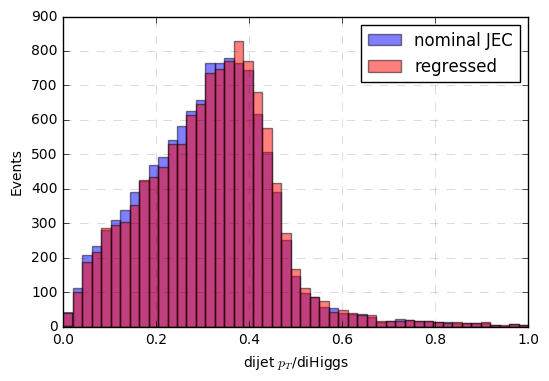

In [115]:
plt.clf()
bins = np.linspace(0,1, 50)
n,bins,patches = plt.hist(df['dijetPt_higgsM_notregressed'],bins=bins,color='blue',alpha=0.5,label='nominal JEC')
n,bins,patches = plt.hist(df['dijetPt_higgsM'],bins=bins,color='red',alpha=0.5,label='regressed')
plt.xlabel('dijet $p_T$/diHiggs')
plt.ylabel('Events')
plt.grid(alpha=0.2,linestyle='--',markevery=2)
axes = plt.gca()
lgd = plt.legend(loc="upper right")
savename='dijetpt_dihiggsM_plot'
plt.savefig(pathsave+savename+'.pdf')
plt.show()

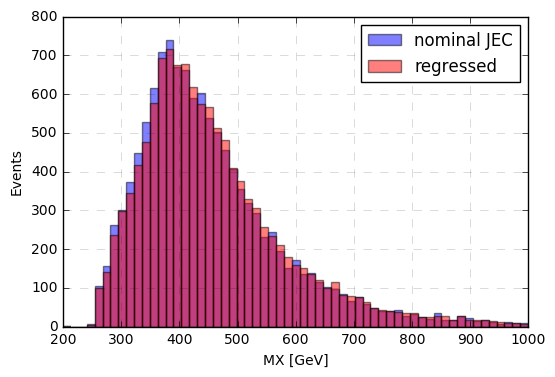

In [116]:
plt.clf()
bins = np.linspace(200, 1000, 60)
n,bins,patches = plt.hist(df['MX_notregressed'],bins=bins,color='blue',alpha=0.5,label='nominal JEC')
n,bins,patches = plt.hist(df['MX'],bins=bins,color='red',alpha=0.5,label='regressed')
plt.xlabel('MX [GeV]')
plt.ylabel('Events')
plt.grid(alpha=0.2,linestyle='--',markevery=2)
axes = plt.gca()
lgd = plt.legend(loc="upper right")
savename='MX_plot'
plt.savefig(pathsave+savename+'.pdf')
plt.show()

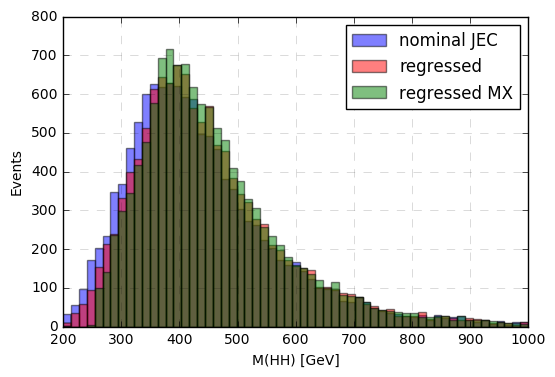

In [118]:
plt.clf()
bins = np.linspace(200, 1000, 60)
n,bins,patches = plt.hist(df['diHiggsM_notregressed'],bins=bins,color='blue',alpha=0.5,label='nominal JEC')
n,bins,patches = plt.hist(df['diHiggs_mass'],bins=bins,color='red',alpha=0.5,label='regressed')
n,bins,patches = plt.hist(df['MX'],bins=bins,color='green',alpha=0.5,label='regressed MX')
plt.xlabel('M(HH) [GeV]')
plt.ylabel('Events')
plt.grid(alpha=0.2,linestyle='--',markevery=2)
axes = plt.gca()
lgd = plt.legend(loc="upper right")
savename='Mhh_plot'
plt.savefig(pathsave+savename+'.pdf')
plt.show()

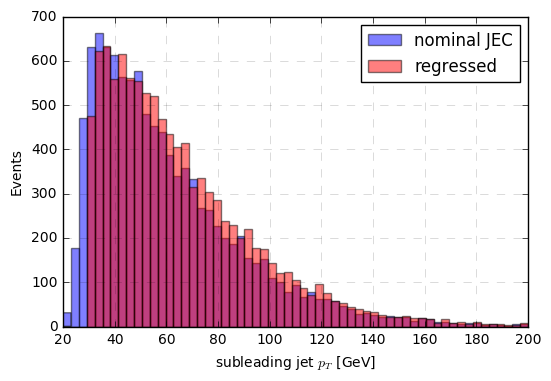

In [122]:
plt.clf()
bins = np.linspace(20, 200, 60)
#n,bins,patches = plt.hist(df.query('leadingJet_pt>20 & subleadingJet_pt>25 & subleadingJet_bDis>0.6')['jet2_pt_notregressed'],bins=bins,color='blue',alpha=0.5,label='nominal JEC')
#n,bins,patches = plt.hist(df.query('leadingJet_pt>20 & subleadingJet_pt>25 & subleadingJet_bDis>0.6')['subleadingJet_pt'],bins=bins,color='red',alpha=0.5,label='regressed')
n,bins,patches = plt.hist(df.query('leadingJet_pt>20 & subleadingJet_pt>30 ')['jet2_pt_notregressed'],bins=bins,color='blue',alpha=0.5,label='nominal JEC')
n,bins,patches = plt.hist(df.query('leadingJet_pt>20 & subleadingJet_pt>30')['subleadingJet_pt'],bins=bins,color='red',alpha=0.5,label='regressed')
plt.xlabel('subleading jet $p_T$ [GeV]')
plt.ylabel('Events')
plt.grid(alpha=0.2,linestyle='--',markevery=2)
axes = plt.gca()
lgd = plt.legend(loc="upper right")
savename='sublead_Jet_pt_plot'
plt.savefig(pathsave+savename+'.pdf')
plt.show()

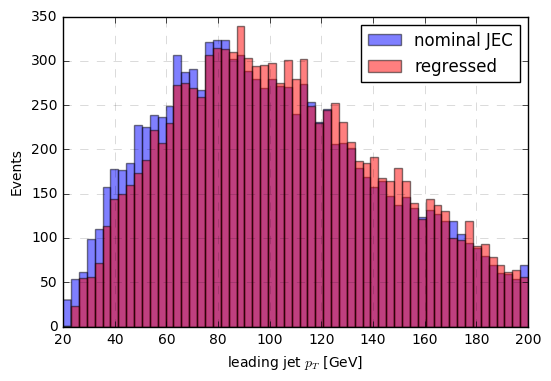

In [123]:
plt.clf()
bins = np.linspace(20, 200, 60)
n,bins,patches = plt.hist(df['jet1_pt_notregressed'],bins=bins,color='blue',alpha=0.5,label='nominal JEC')
n,bins,patches = plt.hist(df['leadingJet_pt'],bins=bins,color='red',alpha=0.5,label='regressed')
plt.xlabel('leading jet $p_T$ [GeV]')
plt.ylabel('Events')
plt.grid(alpha=0.2,linestyle='--',markevery=2)
axes = plt.gca()
lgd = plt.legend(loc="upper right")
savename='lead_Jet_pt_plot'
plt.savefig(pathsave+savename+'.pdf')
plt.show()

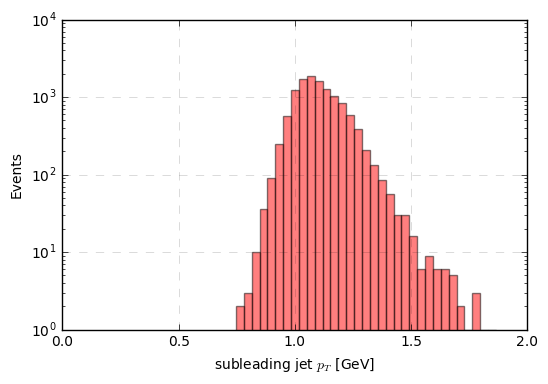

In [124]:
plt.clf()
bins = np.linspace(0, 2, 60)
n,bins,patches = plt.hist(df['subleadingJet_bRegNNCorr'],bins=bins,color='red',alpha=0.5)
plt.yscale('log') 
plt.xlabel('subleading jet $p_T$ [GeV]')
plt.ylabel('Events')
plt.grid(alpha=0.2,linestyle='--',markevery=2)
axes = plt.gca()
#lgd = plt.legend(loc="upper right")
savename='sublead_corr_jetptbin_plot'
plt.savefig(pathsave+savename+'.pdf')
plt.show()

(51,)
50
[ 20.          25.72543919  26.43198105  27.3031102   28.13353127
  29.06936741  30.07031067  31.08483803  32.29089523  33.32019798]
(51,)
50
[ 20.          36.10923531  41.5569516   46.57025452  50.57954208
  54.29685249  57.53916031  60.84511841  63.97254181  66.74658035]


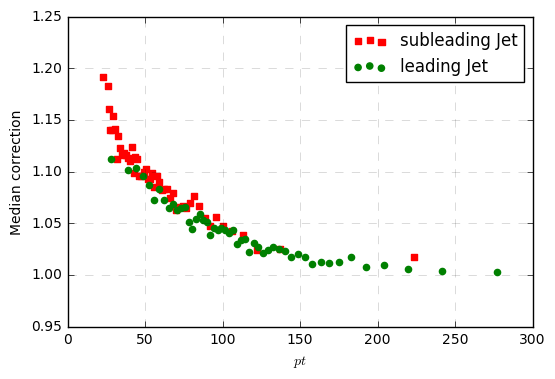

(21,)
20
[-3.         -1.90014922 -1.54347061 -1.26759071 -1.0267926  -0.82969739
 -0.65150118 -0.47882536 -0.3135551  -0.15714157]
(21,)
20
[-3.         -1.79213312 -1.42933532 -1.16792569 -0.95907817 -0.76936407
 -0.59790317 -0.43061276 -0.28428382 -0.12590709]


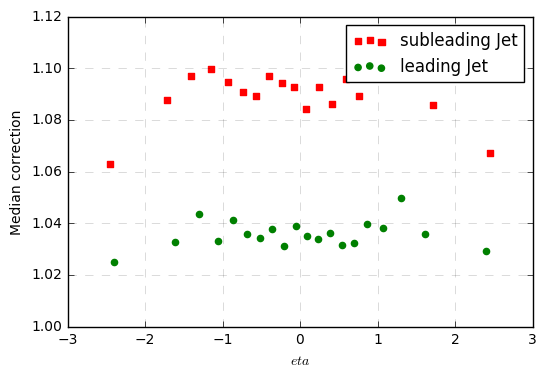

In [125]:
for num_what,what in enumerate(ofwhat):
    for num,obj in enumerate(jets):
        X_what = (df.query('jet1_pt_notregressed>20 & jet2_pt_notregressed>20')['%sJet_%s'%(obj,what)]).values.reshape(-1,1)
        res = (df.query('jet1_pt_notregressed>20 & jet2_pt_notregressed>20')['%sJet_bRegNNCorr'%(obj)]).values.reshape(-1,1)
        ran = ranges[num_what]
        bins = binning[num_what]
        
        bins, y_mean_pt, y_std_pt, y_qt_pt = preprocessing.profile(res,X_what,range=ran,bins=bins,uniform=False,quantiles=np.array([0.25,0.4,0.5,0.75]))
        y_median_pt = y_qt_pt[2]
        y_25_pt,y_40_pt,y_75_pt = y_qt_pt[0],y_qt_pt[1],y_qt_pt[3]
        y_iqr2_pt =  y_qt_pt[0],y_qt_pt[3]
        err_iqr2 =  0.5*(y_qt_pt[3]-y_qt_pt[0])
        binc = 0.5*(bins[1:]+bins[:-1])
        print bins[:10]

        plt.scatter(binc,y_median_pt,color=colors[num],marker=markers[num],label='%s Jet'%obj)

    plt.grid(alpha=0.2,linestyle='--',markevery=2)
    axes = plt.gca()
    ymin, ymax = (plt.gca()).get_ylim()
    xmin, xmax = (plt.gca()).get_xlim()
    lgd = plt.legend(loc="upper right")
    plt.xlabel('$%s$'%what)
    plt.ylabel('Median correction')
  #  savename='plot_correction_%sJet_%s'%(obj,what)
 #   plt.savefig(pathsave+savename+'.pdf')
    plt.show()


In [68]:
df.query('leadingJet_pt>30 & subleadingJet_pt>30').shape

(10626, 84)

In [69]:
df.shape

(12074, 84)

In [70]:
10626./12074

0.8800728838827232

In [81]:
df.query('leadingJet_pt>20 & subleadingJet_pt>20 & subleadingJet_bDis>0.6').shape

(8147, 84)

In [82]:
df.query('leadingJet_pt>20 & subleadingJet_pt>20 ').shape

(12074, 84)

In [83]:
df.query('leadingJet_pt>20 & subleadingJet_pt>20 & leadingJet_bDis>0.6').shape

(9818, 84)

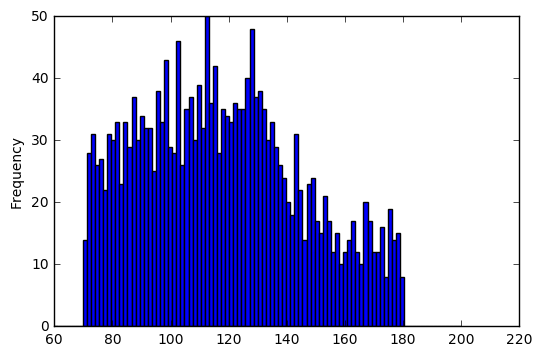

In [94]:
df.query('subleadingJet_bDis<0.3')['Mjj'].plot.hist(bins=100,range=[60,200])
plt.show()

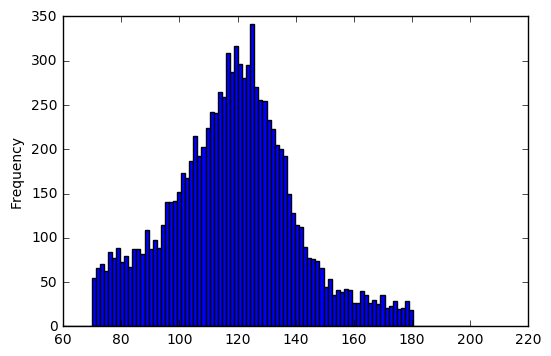

In [95]:
df.query('subleadingJet_bDis>=0.3')['Mjj'].plot.hist(bins=100,range=[60,200])
plt.show()